This notebook is inspired by the chapter "Cells and Diffusion" in the book [Physiochemical and Environmental Plant Physiology](http://www.robertocezar.com.br/documentos/livros/livros/plantphysiology.pdf). We will walk through a very simple example of 1 dimensional diffusion across a membrane and how to solve the differential equation numerically with python.

We will be using [ode](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html) from scipy integrate package.

If you are not familiar with python and the packages used here, get python from [anaconda](https://www.anaconda.com/download/#linux) and follow a tutorial like the [scipy lecture notes](https://www.scipy-lectures.org/) 

In [8]:
''' We import the required libraries
'''
import numpy as np
from scipy.integrate import ode, odeint
from matplotlib import pyplot as plt

# displaying plots inside the notebook (call this before you call plt.style.use())
%matplotlib inline
# for a list of available styles see https://matplotlib.org/gallery/style_sheets/style_sheets_reference.html
plt.style.use('seaborn-muted')

# For displaying images
from IPython.display import Image

## Background

Diffusion across a thin membrane can be described by the well known Fick's 1th law: 

$$ \label{fick_1} J_j = - D_j \, \frac{\partial c_j}{\partial x}$$

The flux density $J_j$ is proportional to the diffusion coefficient $D_j$ of species $j$ and the concentration gradient $\frac{\partial c_j}{\partial x}$ in direction x. The flux density is given in in $mol \, m^{-2} \, s^{-1}$ and the diffusion coefficient in in $mol \, m^{-2} \, s^{-1}$.

The image below shows the case of 1 dimensional diffusion. By convention, a net flow in the direction of increasing x is positive. The minus sign in the equation is needed because flow occurs only towards region with lower concentration ($\partial c_j$ is negative if the concentration on the right side is lower).

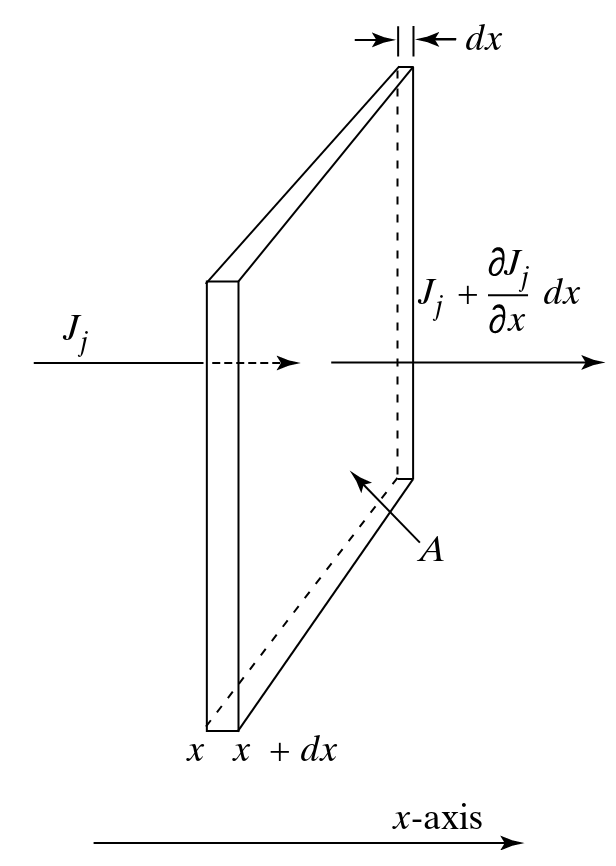

In [9]:
Image('images/1d_diffusion.png', width=200, height=200)

We could ask ourself the question how the concentration of a substance evolves over time would evolve if we place a drop if ink on the left side of the membrane shown above. Currently, we have a relationship between the flux across a membrane and the axial direction:

$$ J_j = - D_j \, \frac{\partial c_j}{\partial x}$$

There is no time there. What to do ?

We can follow the explanations on page 15 of the book [Physiochemical and Environmental Plant Physiology](http://www.robertocezar.com.br/documentos/livros/livros/plantphysiology.pdf) and combine Ficks law with a so called *continuum equation*

$$ \frac{\partial c_j}{\partial t} = -\frac{\partial J_j}{\partial x} $$

The equation states that the change of concentration over time for component $j$ is proportional to the change of the flux density over x. Combined with Fick`s Law we obtain:

$$ \label{fick_2} \frac{\partial c_j}{\partial t} = \frac{\partial}{\partial x} \left( -\frac{\partial J_j}{\partial x} \right) = -\frac{\partial^2 J_j}{\partial x^2}$$

If there is no obstruction between $x$ and $x+dx$ and the solute is placed at position 0, it is possible to derive an analytical expression for equation \ref{fick_2}. However, we would like to consider the diffusion across a membrane:

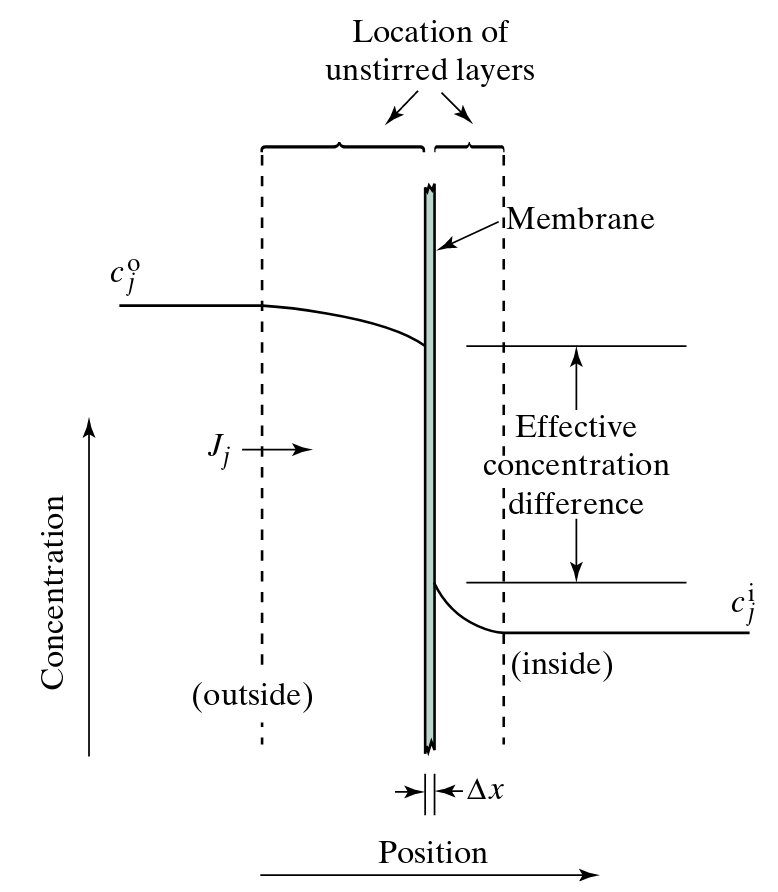

In [3]:
Image('./images/1d_diffusion_membrane.png', height=250, width=250)

If we neglect the boundary layers (between dashed lines) and discretize $\frac{\partial c_j}{\partial x}$ we can express equation \ref{fick_1} as:

$$\label{flux_K} J_j = D_j \, \frac{K_j \, (c_j^i - c_j^0)}{\Delta x} = P_j \, \frac{(c_j^i - c_j^0)}{\Delta x}$$

Because $D_j$ is the diffusion coefficient inside the membrane, we have to take the solubility $K_j$ of species $j$ inside the membrane into account. In order to make life simpler, we can define the Permeability $P_j = D_j \, K_j / \Delta x$ and obtain following equation:

$$\label{flux_P} J_j  = P_j \, (c_j^i - c_j^0)$$

The permeability has the units $m \, s^{-1}$

Let $s_j$ be the amount (in moles) of substance $j$ inside the cell. If we consider that the flux density is is the rate of entry of substance per unit area, we can write:

$$\frac{ds_j}{dt} = J_j \,A = P_j \, A \, (c_j^i - c_j^0)$$

Because $s_j = c_j \, V$ and the Volume (V) inside the cell is nearly constant, we can write:

$$\label{1d_final}\frac{dc_j}{dt} = J_j \,A = \frac{P_j \, A}{V} \, (c_j^i - c_j^0)$$

We will use equation \ref{1d_final} for our calculations

## Time to get the hands dirty

There several convenient packages for solving differential equations: 

- [odeint](https://docs.scipy.org/doc/scipy-1.0.0/reference/generated/scipy.integrate.odeint.html#scipy.integrate.odeint): a simple interface to the FORTRAN library odepack. In many cases this is a good choice due to the simplicity of the interface.

- [ode](https://docs.scipy.org/doc/scipy-1.0.0/reference/generated/scipy.integrate.odeint.html#scipy.integrate.odeint): A generic interface to a couple of integrators. It is not as convenient as *odeint* but you can switch more easily between different integrators. Especially, *lsoda* might be interesting if the system is [stiff](https://en.wikipedia.org/wiki/Stiff_equation).

- [assimulo](http://www.jmodelica.org/assimulo): a wrapper to a wide variety of solvers. Especially, if you would like to solve differential algebraic equations, *assimulo* might be very useful.


We will use the *ode* and *odeint* interface for comparison.

Lets consider a simple example of substance diffusing across a membrane:

### The ode interface

Text(0.5,1,'Concentration over time')

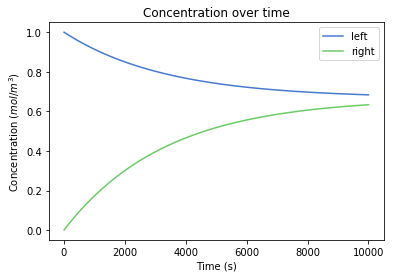

In [5]:
''' Using the ode interface
'''


perm  = 1e-9 # typical permeability of small molecules in (m/s)

# of course the cell is a sphere :)
area_membrane = 1e-1 # membrane area in (m^2)
volume_left = 1e-6 # volume on the left side of the membrane in (m^3)
volume_right = volume_left / 2 # volume on right side of the memrane (initially concentration of 0)

# we need an initial condition for the concentration
c_left = 1e-3 # mol/L
c_right = 0  # no substance outside
y0 = [c_left * 1000, c_right * 1000] # mol/^3

# and an initial condition for the time
t0 = 0

# now we define the ode according to the scipy reference

def ode_1d_diffusion(t, y, area_membrane, perm , volume_left, volume_right):
    dydt = np.zeros(2)
    # describes the concentration change inside the cell
    dydt[0] =   perm * area_membrane / volume_left * (y[1] - y[0])
    # the change outside the cell 
    dydt[1] =  -dydt[0] * volume_left / volume_right
    
    return dydt

r = ode(ode_1d_diffusion).set_integrator('lsoda')
r.set_f_params(area_membrane, perm , volume_left, volume_right)
r.set_initial_value(y0, t0)

# we set a delta time at which we would like to obtain a solution
dt = 10 # second
t_end = 10000

# This part might be a little bit inconvenient at firts. We have to iterate throug the timepoints
# and store the time in lists as well as the solutions for both concentrations
t = []
sol = []
while r.successful() and r.t < t_end:
    t.append(r.t+dt)
    sol.append(r.integrate(r.t+dt))

# convert the lists to numpy array for more convenient indexingQ
t = np.asarray(t)
sol = np.asarray(sol)

# plot the concentration on the left side of the membrane (by our function definition y[0])
plt.plot(t, sol[:,0], label='left')

# plot the concentration on the left side of the membrane (by our function definition y[1])
plt.plot(t, sol[:,1], label='right')

plt.legend(loc=0)
# yes, matplotlib can handle Latex
plt.ylabel('Concentration ($mol/m^3$)')
plt.xlabel('Time (s)')
plt.title('Concentration over time')

### The odeint interface

Text(0.5,1,'Concentration over time')

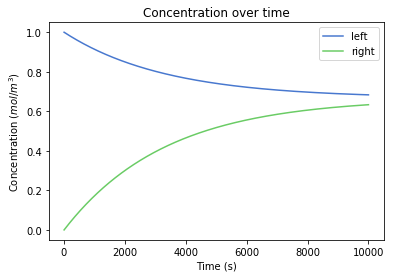

In [6]:
''' Quite similar to the previous example
'''


perm  = 1e-9 # typical permeability in (m/s)

# of course the cell is a sphere :)
area_membrane = 1e-1 # membrane area in (m^2)
volume_left = 1e-6 # volume on the left side of the membrane in (m^3)
volume_right = volume_left / 2 # volume on right side of the memrane (initially concentration of 0)

# we need an initial condition for the concentration
c_left = 1e-3 # mol/L
c_right = 0  # no substance outside
y0 = [c_left * 1000, c_right * 1000] # mol/^3

# and an initial condition for the time
t0 = 0

# now we define the ode according to the scipy reference (NOTE: y,t are in different order than before)

def ode_1d_diffusion(y, t, area_membrane, perm , volume_left, volume_right):
    dydt = np.zeros(2)
    # describes the concentration change inside the cell
    dydt[0] =   perm * area_membrane / volume_left * (y[1] - y[0])
    # the change outside the cell 
    dydt[1] =  -dydt[0] * volume_left / volume_right
    
    return dydt

# The call to the solver is just one line
t_end = np.linspace(0, 1000)
sol = odeint(ode_1d_diffusion, y0, t, args=(area_membrane, perm , volume_left, volume_right))

# plot the concentration on the left side of the membrane (by our function definition y[0])
plt.plot(t, sol[:,0], label='left')

# plot the concentration on the left side of the membrane (by our function definition y[1])
plt.plot(t, sol[:,1], label='right')

plt.legend(loc=0)
# yes, matplotlib can handle Latex
plt.ylabel('Concentration ($mol/m^3$)')
plt.xlabel('Time (s)')
plt.title('Concentration over time')